## Исследовательский анализ данных

In [1]:
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import sys
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image

In [2]:
path = '/datasets/faces/final_files/'

Посмотрим данные

In [3]:
labels = pd.read_csv('/datasets/faces/labels.csv')
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory= path,
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345) 

Found 7591 validated image filenames.


Посмотрим на размер выборки

In [4]:
sample_size = len(labels)
print("Размер выборки:", sample_size)

Размер выборки: 7591


In [9]:
### пример кода c f-строкой
print(f"Размер выборки : {sample_size}")

Размер выборки : 7591


Построим график распределения возраста в выборке

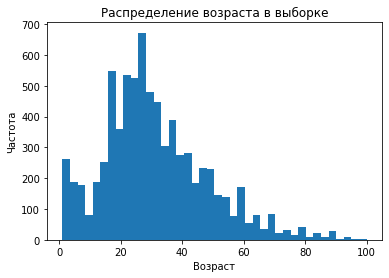

In [5]:
plt.hist(labels['real_age'], bins=40)
plt.xlabel('Возраст')
plt.ylabel('Частота / Количество наблюдений')
plt.title('Распределение возраста в выборке')
plt.show()

In [6]:
labels.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


- Размер выборки составляет 7,591 наблюдение. Это достаточно большой объем данных для обучения модели.

- Смещение данных: Медианное значение возраста (50-й процентиль) равно 29 годам, в то время как средний возраст составляет около 31.2 года. Это указывает на некоторое смещение данных вправо (положительное смещение). Такое смещение может быть вызвано наличием небольшого количества выбросов с более высокими значениями возраста

- Стандартное отклонение возраста равно примерно 17.1. Модель, обученная на таком разнообразном наборе возрастов, может быть достаточно универсальной и способной к обобщению на новые данные.

- Минимальный возраст в выборке составляет 1 год, а максимальный возраст - 100 лет. Это говорит о широком диапазоне возрастов, представленных в данных.

Исходя из этих статистических данных, можно сделать вывод, что набор данных представляет широкий спектр возрастов, с разбросом от маленького детского возраста до пожилых людей. Это может потребовать настройки модели и принятия во внимание особенностей различных возрастных групп при обучении модели, чтобы достичь оптимальных результатов.


<div style="background: #B0E0E6; padding: 5px; border: 1px solid SteelBlue; border-radius: 5px;">
    <font color='4682B4'>
    <font color='4682B4'> 
В целом выборка имеет распределение похожее на нормальное. 1-й пик значений около 27 лет, также есть небольшой пик в значениях возраста до 10 лет. 
После 20 лет наблюдаем минипики, на значениях кратных 10. Возможно, это связано с округлением возраста до 10 лет при разметке в случае, если возраст человека на фотографии не был точно известен.
        
Относительно аномальных пиков на графике распределения целевой переменной, возможно, следующие объяснения:

Выбросы: Пики, которые выделяются от основного распределения, могут быть связаны с наличием выбросов или экстремальных значений возраста в выборке. Это могут быть необычные случаи, ошибки в данных или особенности набора данных, которые приводят к таким выбросам.

Сегментация возрастных групп: Другим объяснением может быть сегментация выборки по конкретным возрастным группам или категориям, что приводит к формированию пиков на графике. Например, если данные разделены на группы "дети", "взрослые" и "пожилые", то это может привести к видимым пикам в каждой группе.
        
   </font>
</div>

Напечатаем на экране 15 фотографий и посмотим, как устроен датасет

In [3]:
# Получим 10-15 фотографий из выборки
sample_images = labels.sample(15)

# Проверим фактическое количество доступных изображений
num_images = len(sample_images)
print("Фактическое количество доступных изображений:", num_images)

# Изменим количество строк и столбцов в subplots в соответствии с фактическим количеством изображений
num_rows = (num_images - 1) // 5 + 1
num_cols = min(num_images, 5)

# Отобразим фотографии
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(12, 8))

for i, row in enumerate(sample_images.itertuples(), 1):
    img_path = path + row.file_name
    img = plt.imread(img_path)
    axes[(i - 1) // num_cols, (i - 1) % num_cols].imshow(img)
    axes[(i - 1) // num_cols, (i - 1) % num_cols].axis('off')

plt.tight_layout()
plt.show()

Все фото одинакового размера (квадратные) и содержат только лица. Поэтому предобратка датасета не требуется. При этом загрузчик данных приведет все изображения к целефой форме 224 на 224 пикселя.

## Обучение модели

Используем модель ResNet50 с функцией активации relu для применения сети для задачи регрессии.
Данная модель была обучена на локальном компьютере.

Запишем код.

```python

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow import keras
import pandas as pd

path = '/datasets/faces/final_files/'
wpath = '/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5'

# Загрузка обучающего набора данных из папки 'path`
def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    datagen = ImageDataGenerator(
        validation_split=0.25,
        rescale=1/255.,
        horizontal_flip=True,
        width_shift_range=0.15,
        height_shift_range=0.15,
        zoom_range=0.1,
    )

    return datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path,
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=123,
    )

# Загрузка тестового набора данных из папки 'path`
def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    datagen = ImageDataGenerator(
        validation_split=0.25,
        rescale=1/255.)

    return datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path,
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=123,
    )

# Создание модели ResNet50 с загрузкой готовых весов.
# Добавление пользовательского полносвязного слоя сверху с активацией `relu` для предсказания возраста.

def create_model(input_shape):
    backbone = ResNet50(
        weights=wpath,
        input_shape=input_shape,
        include_top=False)

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
    model.compile(optimizer=Adam(learning_rate=0.0005),
                  loss='mean_squared_error', metrics=['mean_absolute_error'])
    return model

"""Обучение модели `model`

train_data         : DataFrameIterator для обучающего набора данных
test_data          : DataFrameIterator для набора данных валидации
epochs, batch_size : параметры keras.Model.fit()

Returns:
model (keras.Model): Обученная модель
"""
def train_model(model, train_data, test_data, batch_size=None, epochs=20,
                steps_per_epoch=None, validation_steps=None):
    model.fit(train_data,
              validation_data=test_data,
              epochs=epochs, batch_size=batch_size,
              steps_per_epoch=steps_per_epoch,  # train_data.samples/train_data.batch_size,
              validation_steps=validation_steps,  # test_data.samples/test_data.batch_size,
              verbose=2, shuffle=True)
    return model

```

```

Found 5694 validated image filenames.

Found 1897 validated image filenames.

...Devices:

2023-06-18 05:30:25.544135: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Tesla V100-SXM2-32GB, Compute Capability 7.0

...
Train for 178 steps, validate for 60 steps

Epoch 1/20
....
178/178 - 100s - loss: 217.4510 - mean_absolute_error: 10.9406 - val_loss: 286.1032 - val_mean_absolute_error: 12.8756

Epoch 2/20
178/178 - 93s - loss: 125.8219 - mean_absolute_error: 8.4875 - val_loss: 361.2077 - val_mean_absolute_error: 13.9963

Epoch 3/20
178/178 - 92s - loss: 109.8990 - mean_absolute_error: 7.9731 - val_loss: 340.0013 - val_mean_absolute_error: 13.5622

Epoch 4/20
178/178 - 92s - loss: 96.0345 - mean_absolute_error: 7.4426 - val_loss: 188.2284 - val_mean_absolute_error: 10.4035

Epoch 5/20
178/178 - 91s - loss: 90.4977 - mean_absolute_error: 7.1224 - val_loss: 101.0601 - val_mean_absolute_error: 7.8089

Epoch 6/20
178/178 - 92s - loss: 87.6187 - mean_absolute_error: 7.0929 - val_loss: 101.1436 - val_mean_absolute_error: 7.6857

Epoch 7/20
178/178 - 92s - loss: 76.4310 - mean_absolute_error: 6.6128 - val_loss: 131.9612 - val_mean_absolute_error: 8.6983

Epoch 8/20
178/178 - 92s - loss: 74.0372 - mean_absolute_error: 6.5270 - val_loss: 90.0899 - val_mean_absolute_error: 7.2912

Epoch 9/20
178/178 - 89s - loss: 68.8214 - mean_absolute_error: 6.2568 - val_loss: 265.7301 - val_mean_absolute_error: 13.0692

Epoch 10/20
178/178 - 89s - loss: 64.2670 - mean_absolute_error: 6.0966 - val_loss: 176.6956 - val_mean_absolute_error: 10.0382

Epoch 11/20
178/178 - 89s - loss: 63.9211 - mean_absolute_error: 6.1007 - val_loss: 114.0499 - val_mean_absolute_error: 8.0275

Epoch 12/20
178/178 - 89s - loss: 61.3102 - mean_absolute_error: 5.9573 - val_loss: 143.2438 - val_mean_absolute_error: 9.1002

Epoch 13/20
178/178 - 89s - loss: 58.6244 - mean_absolute_error: 5.8191 - val_loss: 200.4709 - val_mean_absolute_error: 10.4924

Epoch 14/20
178/178 - 89s - loss: 52.7222 - mean_absolute_error: 5.5188 - val_loss: 84.4685 - val_mean_absolute_error: 6.9735

Epoch 15/20
178/178 - 89s - loss: 52.8567 - mean_absolute_error: 5.5308 - val_loss: 117.3572 - val_mean_absolute_error: 8.6011

Epoch 16/20
178/178 - 89s - loss: 58.1594 - mean_absolute_error: 5.7855 - val_loss: 107.1864 - val_mean_absolute_error: 8.3435

Epoch 17/20
178/178 - 89s - loss: 50.9032 - mean_absolute_error: 5.4171 - val_loss: 84.4378 - val_mean_absolute_error: 6.7631

Epoch 18/20
178/178 - 89s - loss: 46.5250 - mean_absolute_error: 5.2040 - val_loss: 113.9315 - val_mean_absolute_error: 8.0716

Epoch 19/20
178/178 - 89s - loss: 40.9729 - mean_absolute_error: 4.8547 - val_loss: 93.4059 - val_mean_absolute_error: 7.1614

Epoch 20/20
178/178 - 89s - loss: 39.6958 - mean_absolute_error: 4.8382 - val_loss: 70.3920 - val_mean_absolute_error: 6.2570
...

60/60 - 10s - loss: 70.3920 - mean_absolute_error: 6.2570

Test MAE: 6.2570

```

## Анализ обученной модели

<div style="background: #B0E0E6; padding: 5px; border: 1px solid SteelBlue; border-radius: 5px;">
    <font color='4682B4'>
    <font color='4682B4'> Получили значение метрики mean_absolute_error на тесте 6.2570. На обучающей выборке - 4.8382. Т.е. при использовании данной модели для детекции возраста мы будем ошибаться в среднем +- на 6.5 лет. Т.е. для отсечки на алкоголь и сигареты, модель слабовата.

При этом на всех эпохах заметно подобное снижение метрики на тестовых данных. Т.е. можно сказать, что сама мадель (ее архитектура) недостатосно совершенна для решения подобной задачи. Также возможно сделать предположение, что увеличение объема данных и количества эпох обучения может увеличить метрику.
        
   </font>
</div>